In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/probabilistic-modelling-24-classify-the-market/sample_submission.csv
/kaggle/input/probabilistic-modelling-24-classify-the-market/train.csv
/kaggle/input/probabilistic-modelling-24-classify-the-market/test.csv


# Reading Data

In [2]:
train_df = pd.read_csv('/kaggle/input/probabilistic-modelling-24-classify-the-market/train.csv')
train_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,0
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,2
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,0
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,1
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,0
...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,0
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,0
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,0
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,2


In [3]:
tst_df = pd.read_csv('/kaggle/input/probabilistic-modelling-24-classify-the-market/test.csv')
tst_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3
...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1
5677,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3
5678,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2
5679,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2


In [4]:
#El format elly n3ml beha el submission
sample = pd.read_csv('/kaggle/input/probabilistic-modelling-24-classify-the-market/sample_submission.csv')
sample

,row_id,label
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1
...,...,...
5676,5676,-1
5677,5677,-1
5678,5678,-1
5679,5679,-1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      8523 non-null   object 
 1   X2      7060 non-null   float64
 2   X3      8523 non-null   object 
 3   X4      8523 non-null   float64
 4   X5      8523 non-null   object 
 5   X6      8523 non-null   float64
 6   X7      8523 non-null   object 
 7   X8      8523 non-null   int64  
 8   X9      6113 non-null   object 
 9   X10     8523 non-null   object 
 10  Y       8523 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 732.6+ KB


In [6]:
categ_cols = []
num_cols = []

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        categ_cols.append(col)
    else:
        num_cols.append(col)

categ_cols

['X1', 'X3', 'X5', 'X7', 'X9', 'X10']

# EDA

In [7]:
train_df['Y'].unique()

array([0, 2, 1, 3])

## Categorical Data

In [8]:
for col in categ_cols:
    print(f'Number of unique values in {col}: {train_df[col].nunique()}')
    if train_df[col].nunique() < 50:
        print(f'Unique values in {col}: {train_df[col].unique()}')

Number of unique values in X1: 1559
Number of unique values in X3: 5
Unique values in X3: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Number of unique values in X5: 16
Unique values in X5: ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Number of unique values in X7: 10
Unique values in X7: ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Number of unique values in X9: 3
Unique values in X9: ['Medium' nan 'High' 'Small']
Number of unique values in X10: 3
Unique values in X10: ['Tier 1' 'Tier 3' 'Tier 2']


### Nulls

In [9]:
train_df[categ_cols].isnull().sum()

X1        0
X3        0
X5        0
X7        0
X9     2410
X10       0
dtype: int64

We have to substitute the nulls in X9 somehow. We will try mode replacement, knn_imbuter, and then keeping it as an "unknown" category.

In [10]:
train_df["X9"].value_counts()

X9
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [11]:
imputer = SimpleImputer(strategy='most_frequent')
train_df['imputed_X9'] = imputer.fit_transform(train_df[['X9']]).ravel()

train_df['unk_X9']=train_df['X9'].fillna('Unknown')

train_df['X9']=train_df['X9'].fillna('Medium')

In [12]:
train_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,imputed_X9,unk_X9
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,0,Medium,Medium
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,2,Medium,Medium
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,0,Medium,Medium
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,1,Medium,Unknown
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,0,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,0,High,High
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Medium,Tier 2,0,Medium,Unknown
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,0,Small,Small
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,2,Medium,Medium


In [13]:
X9 = ['X9','imputed_X9', 'unk_X9']
for col in X9:
    print(f'{train_df[col].value_counts()}')
    print('-----------------------------')

X9
Medium    5203
Small     2388
High       932
Name: count, dtype: int64
-----------------------------
imputed_X9
Medium    5203
Small     2388
High       932
Name: count, dtype: int64
-----------------------------
unk_X9
Medium     2793
Unknown    2410
Small      2388
High        932
Name: count, dtype: int64
-----------------------------


We now see that the imputed column has the same distribution as the mode column. Usually we would only keep the mode column given that it is less computationally intensive but since out dataset is small anyway we will keep the knn imputer.

### Encoding

In [14]:
# We will manually encode so that we know which categ is which and have it be the same acros the 3 columns
# train_df['unk_X9']=train_df['X9'].fillna('Unknown')
mapping_X9 = {'Unknown': 0, 'Small': 1, 'Medium': 2, 'High': 3}
# train_df['X9'] = train_df['X9'].map(mapping_X9)

In [15]:
train_df['imputed_X9'] = train_df['imputed_X9'].map(mapping_X9)
train_df['unk_X9'] = train_df['unk_X9'].map(mapping_X9)
train_df['X9'] = train_df['X9'].map(mapping_X9)
train_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,imputed_X9,unk_X9
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,2,Tier 1,0,2,2
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,2,Tier 3,2,2,2
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,2,Tier 1,0,2,2
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,2,Tier 3,1,2,0
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,3,Tier 3,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,3,Tier 3,0,3,3
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,2,Tier 2,0,2,0
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,1,Tier 2,0,1,1
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,2,Tier 3,2,2,2


In [16]:
train_df['X1'].value_counts()

X1
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

Because X1 has 1559 unique values which will be too many to encode and possibly do not correlate to the target we will use frequency encoding to decrease the number of values (values with repeated frequencies end up as 1 value).

In [17]:
frequency_encoding = train_df['X1'].value_counts().to_dict()
train_df['X1'] = train_df['X1'].map(frequency_encoding)

In [18]:
train_df['X1'].value_counts()

X1
6     2298
5     1975
7     1771
4      936
8      880
3      339
9      225
2       70
10      20
1        9
Name: count, dtype: int64

In [19]:
train_df['X3'].value_counts()

X3
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

X3 only has 2 values but in different format so we will fix that.

In [20]:
train_df['X3'] = train_df['X3'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
train_df['X3'].value_counts()

X3
Low Fat    5517
Regular    3006
Name: count, dtype: int64

The rest of the remaining categ columns are ready to be encoded but X10 will be ordinally encoded because it is obviously ordered.

In [21]:
oe_X10 = OrdinalEncoder(categories=[['Tier 1', 'Tier 2', 'Tier 3']])
train_df['X10'] = oe_X10.fit_transform(train_df[['X10']])

In [22]:
le_X3 = LabelEncoder()
train_df['X3'] = le_X3.fit_transform(train_df['X3'])

le_X5 = LabelEncoder()
train_df['X5'] = le_X5.fit_transform(train_df['X5'])

le_X7 = LabelEncoder()
train_df['X7'] = le_X7.fit_transform(train_df['X7'])

# hshof el mapping
category_mapping = dict(zip(le_X3.classes_, le_X3.transform(le_X3.classes_)))
print(category_mapping)  

category_mapping = dict(zip(le_X5.classes_, le_X5.transform(le_X5.classes_)))
print(category_mapping) 

category_mapping = dict(zip(le_X7.classes_, le_X7.transform(le_X7.classes_)))
print(category_mapping) 

{'Low Fat': 0, 'Regular': 1}
{'Baking Goods': 0, 'Breads': 1, 'Breakfast': 2, 'Canned': 3, 'Dairy': 4, 'Frozen Foods': 5, 'Fruits and Vegetables': 6, 'Hard Drinks': 7, 'Health and Hygiene': 8, 'Household': 9, 'Meat': 10, 'Others': 11, 'Seafood': 12, 'Snack Foods': 13, 'Soft Drinks': 14, 'Starchy Foods': 15}
{'OUT010': 0, 'OUT013': 1, 'OUT017': 2, 'OUT018': 3, 'OUT019': 4, 'OUT027': 5, 'OUT035': 6, 'OUT045': 7, 'OUT046': 8, 'OUT049': 9}


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X1          8523 non-null   int64  
 1   X2          7060 non-null   float64
 2   X3          8523 non-null   int64  
 3   X4          8523 non-null   float64
 4   X5          8523 non-null   int64  
 5   X6          8523 non-null   float64
 6   X7          8523 non-null   int64  
 7   X8          8523 non-null   int64  
 8   X9          8523 non-null   int64  
 9   X10         8523 non-null   float64
 10  Y           8523 non-null   int64  
 11  imputed_X9  8523 non-null   int64  
 12  unk_X9      8523 non-null   int64  
dtypes: float64(4), int64(9)
memory usage: 865.7 KB


## Numerical Data

In [24]:
num_cols = ['X2', 'X4', 'X6', 'X8']
for col in num_cols:
    print(f'Number of unique values in {col}: {train_df[col].nunique()}')
    if train_df[col].nunique() < 50:
        print(f'Unique values in {col}: {train_df[col].unique()}')

Number of unique values in X2: 415
Number of unique values in X4: 7880
Number of unique values in X6: 5938
Number of unique values in X8: 9
Unique values in X8: [1999 2009 1998 1987 1985 2002 2007 1997 2004]


We can assume that X8 contains a year related to something in the dataset

### Nulls

In [25]:
train_df[num_cols].isnull().sum()

X2    1463
X4       0
X6       0
X8       0
dtype: int64

In [26]:
X2_imputer = SimpleImputer(strategy='median')
train_df['X2'] = X2_imputer.fit_transform(train_df[['X2']])
train_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,imputed_X9,unk_X9
0,8,9.300,0,0.016047,4,249.8092,9,1999,2,0.0,0,2,2
1,6,5.920,1,0.019278,14,48.2692,3,2009,2,2.0,2,2,2
2,7,17.500,0,0.016760,10,141.6180,9,1999,2,0.0,0,2,2
3,6,19.200,1,0.000000,6,182.0950,0,1998,2,2.0,1,2,0
4,6,8.930,0,0.000000,9,53.8614,1,1987,3,2.0,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,8,6.865,0,0.056783,13,214.5218,1,1987,3,2.0,0,3,3
8519,6,8.380,1,0.046982,0,108.1570,7,2002,2,1.0,0,2,0
8520,6,10.600,0,0.035186,8,85.1224,6,2004,1,1.0,0,1,1
8521,6,7.210,1,0.145221,13,103.1332,3,2009,2,2.0,2,2,2


In [27]:
train_df[num_cols].isnull().sum()

X2    0
X4    0
X6    0
X8    0
dtype: int64

### Outliers

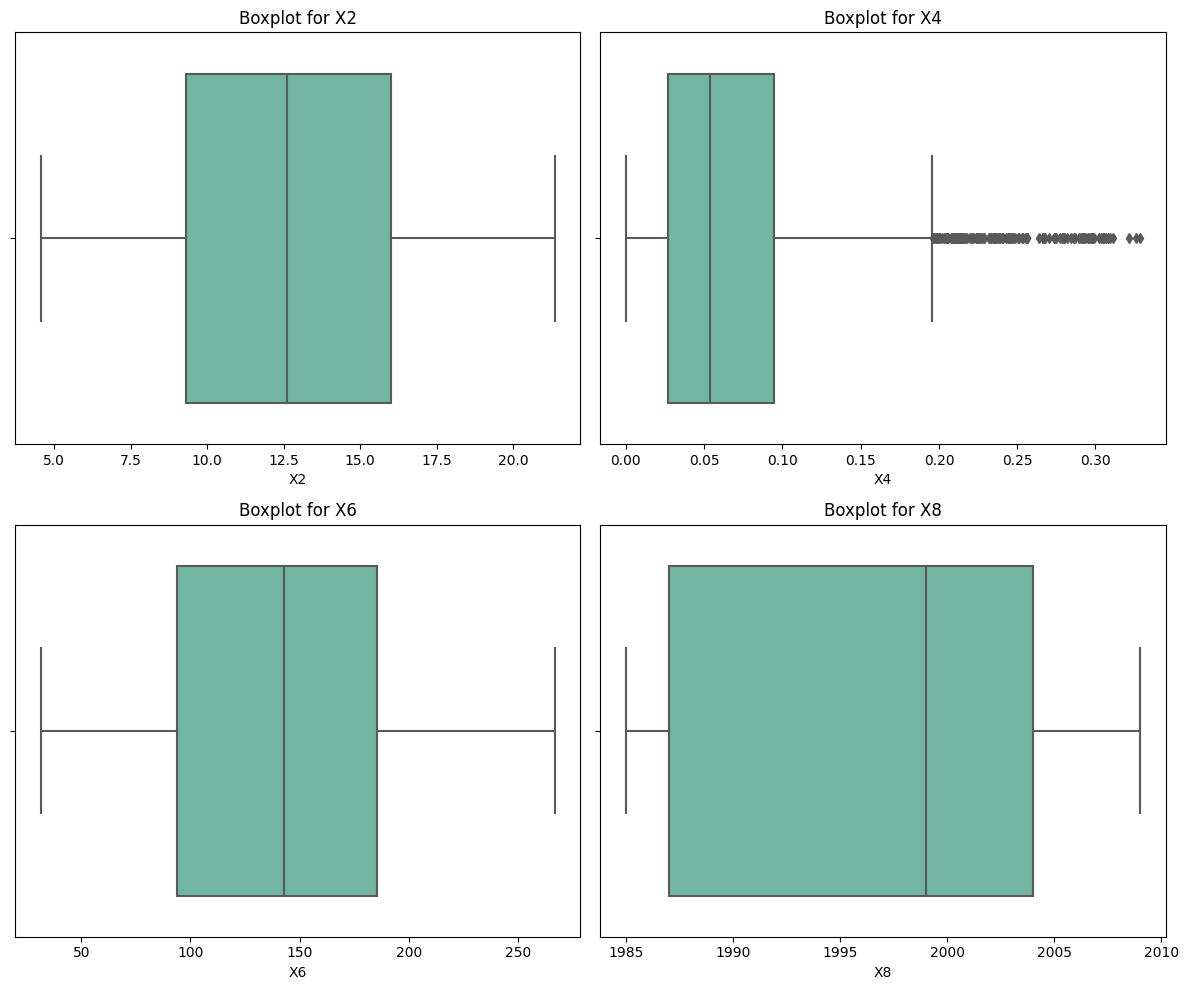

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(ax=axes[i], data=train_df, x=col, palette='Set2')
    axes[i].set_title(f'Boxplot for {col}')

plt.tight_layout()

plt.show()

X4 is the only one with outliers, so we will handle those.

In [29]:
lower_bound_X4 = train_df['X4'].quantile(0.05)
upper_bound_X4 = train_df['X4'].quantile(0.95)
train_df['X4'] = train_df['X4'].clip(lower=lower_bound_X4, upper=upper_bound_X4)

# from scipy.stats import mstats
# train_df['X4'] = mstats.winsorize(train_df['X4'], limits=[0.05, 0.05])
# same output bs a7sn yb2a 3ndi value el bounds 34an lw hst5dmha 3la el test

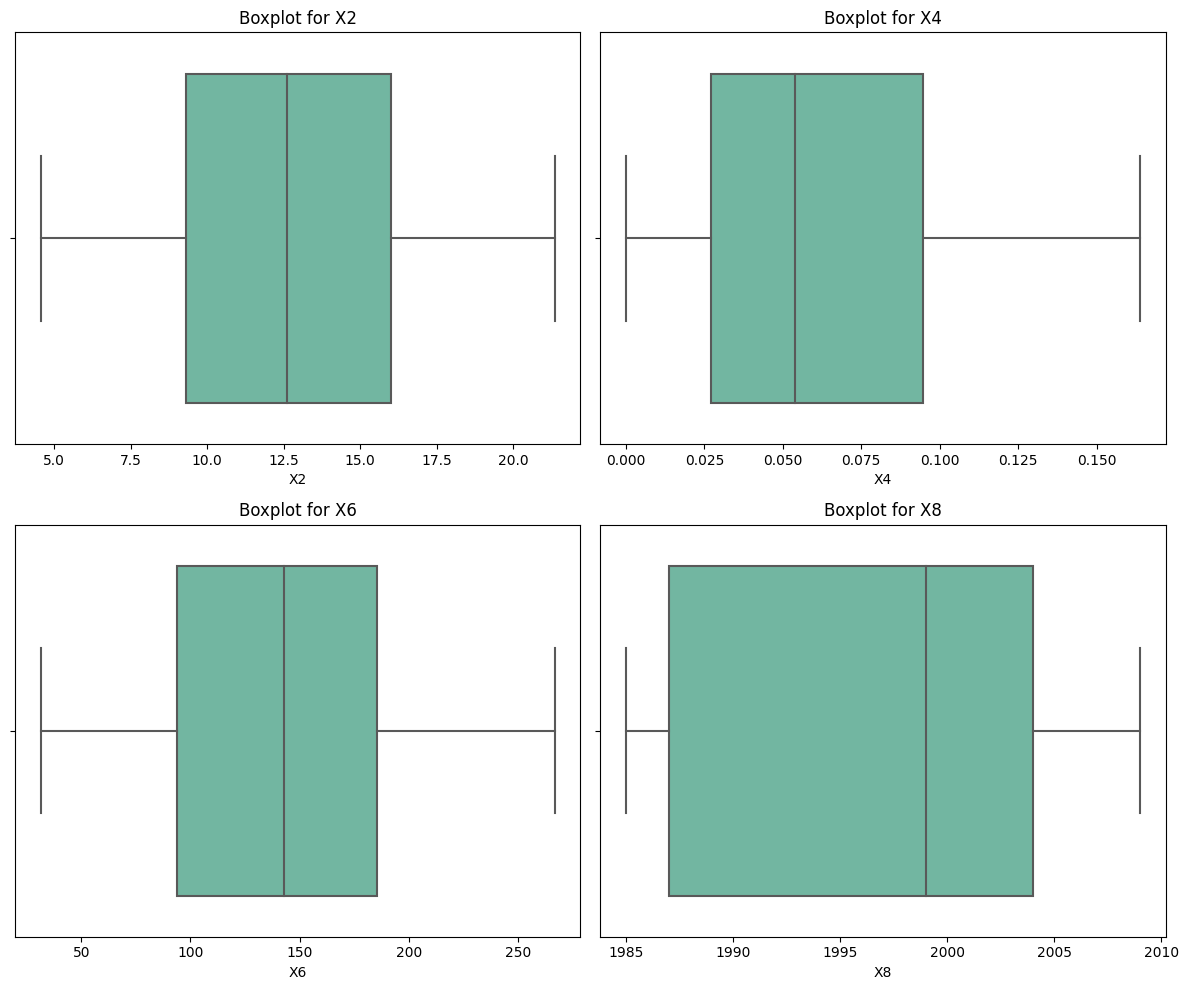

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(ax=axes[i], data=train_df, x=col, palette='Set2')
    axes[i].set_title(f'Boxplot for {col}')

plt.tight_layout()

plt.show()

### Skew

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

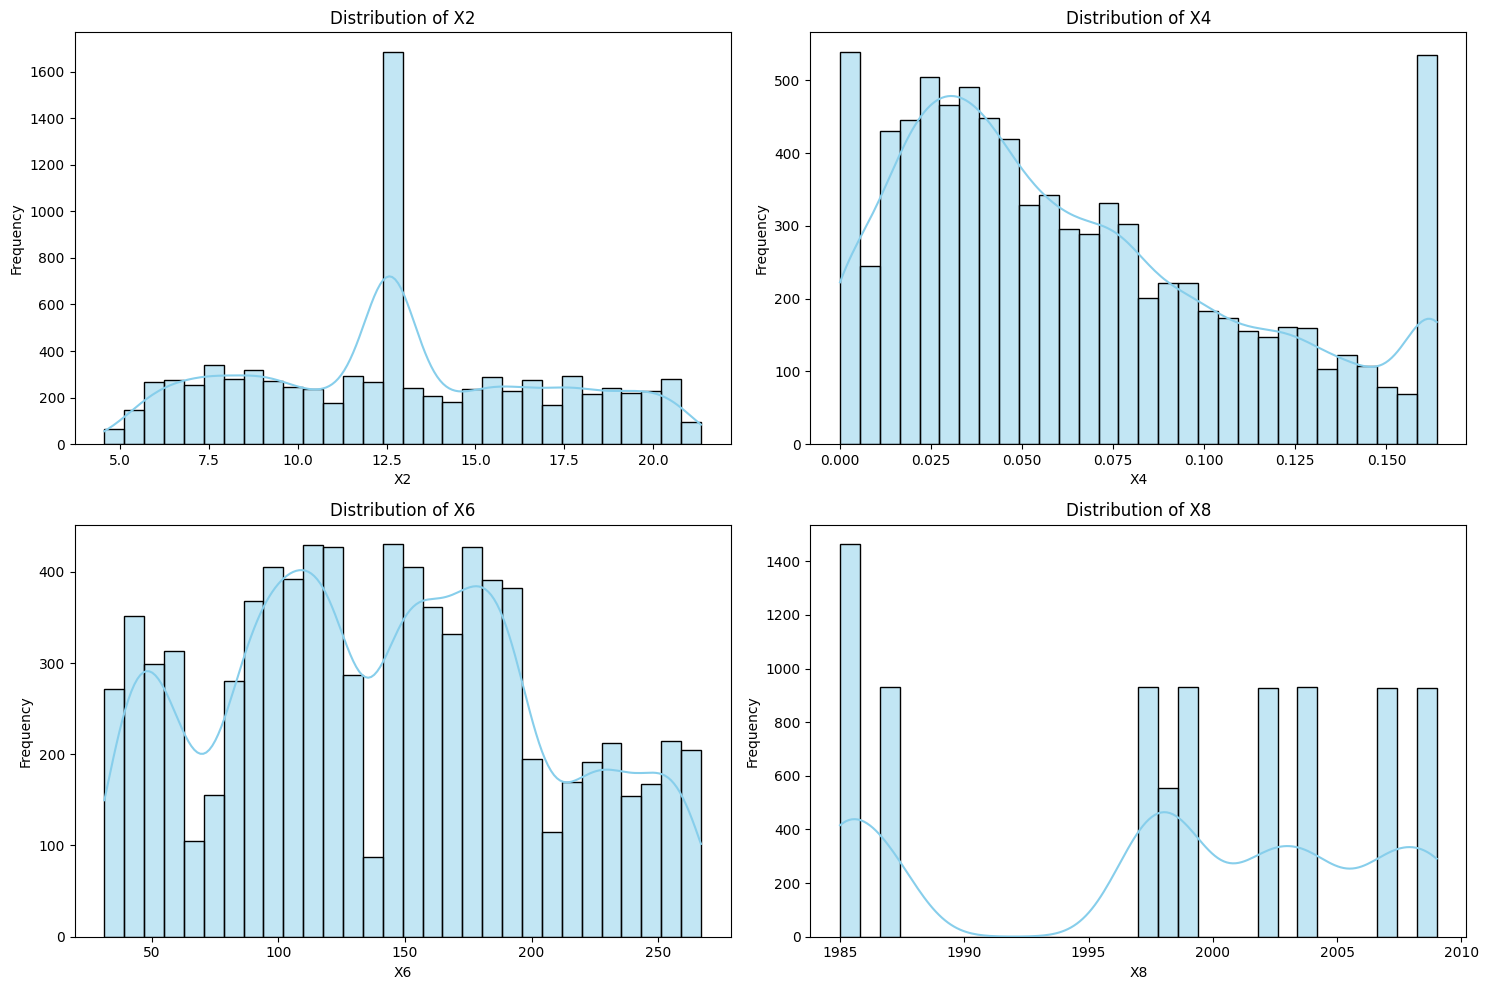

In [31]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)  
    sns.histplot(train_df[col], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
for col in num_cols:
    print(f'Skewness of {col}: {skew(train_df[col].dropna())}')

Skewness of X2: 0.12182405058759048
Skewness of X4: 0.6451731854251368
Skewness of X6: 0.12717988033368544
Skewness of X8: -0.39657097595805835


Skew is small for all of them, no need to handle.

### Scale

In [33]:
train_df[num_cols].describe()

,X2,X4,X6,X8
count,8523.00000,8523.000000,8523.000000,8523.000000
mean,12.81342,0.064353,140.992782,1997.831867
std,4.22724,0.046606,62.275067,8.371760
min,4.55500,0.000000,31.290000,1985.000000
25%,9.31000,0.026989,93.826500,1987.000000
50%,12.60000,0.053931,143.012800,1999.000000
75%,16.00000,0.094585,185.643700,2004.000000
max,21.35000,0.163780,266.888400,2009.000000


In [34]:
# num_col_scaler = StandardScaler()
# train_df[num_cols] = num_col_scaler.fit_transform(train_df[num_cols])
num_col_scaler = MinMaxScaler()

# Apply Min-Max scaling
train_df[num_cols] = num_col_scaler.fit_transform(train_df[num_cols])
train_df[num_cols].describe()

,X2,X4,X6,X8
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,0.491719,0.392926,0.465635,0.534661
std,0.251696,0.284564,0.264327,0.348823
min,0.000000,0.000000,0.000000,0.000000
25%,0.283120,0.164791,0.265437,0.083333
50%,0.479012,0.329289,0.474209,0.583333
75%,0.681453,0.577515,0.655156,0.791667
max,1.000000,1.000000,1.000000,1.000000


## Correlation

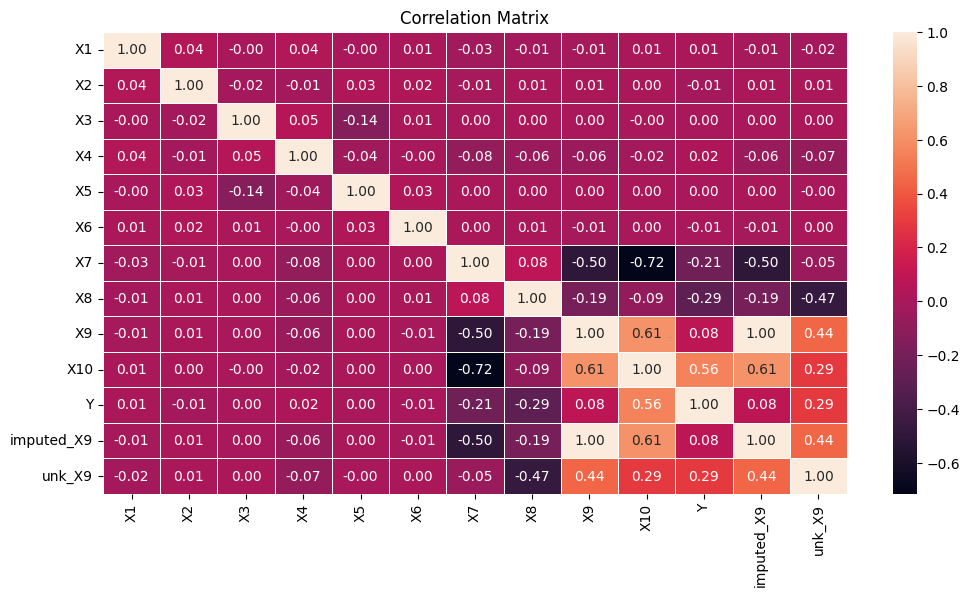

In [35]:
# Step 1: Calculate the correlation matrix for numerical columns
correlation_matrix = train_df.corr()

# Step 2: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We can see that out of the X9 columns, unk_X9 (where we replaced the nan with 'Unknown') has the highest correlation with Y. So we will keep it and drop the others.

In [36]:
train_df['X9']=train_df['unk_X9']
train_df.drop(columns=['unk_X9', 'imputed_X9'], inplace=True)
train_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,8,0.282525,0,0.097981,4,0.927507,9,0.583333,2,0.0,0
1,6,0.081274,1,0.117708,14,0.072068,3,1.000000,2,2.0,2
2,7,0.770765,0,0.102333,10,0.468288,9,0.583333,2,0.0,0
3,6,0.871986,1,0.000000,6,0.640093,0,0.541667,0,2.0,1
4,6,0.260494,0,0.000000,9,0.095805,1,0.083333,3,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...
8518,8,0.137541,0,0.346706,13,0.777729,1,0.083333,3,2.0,0
8519,6,0.227746,1,0.286863,0,0.326263,7,0.708333,0,1.0,0
8520,6,0.359929,0,0.214839,8,0.228492,6,0.791667,1,1.0,0
8521,6,0.158083,1,0.886682,13,0.304939,3,1.000000,2,2.0,2


## PCA

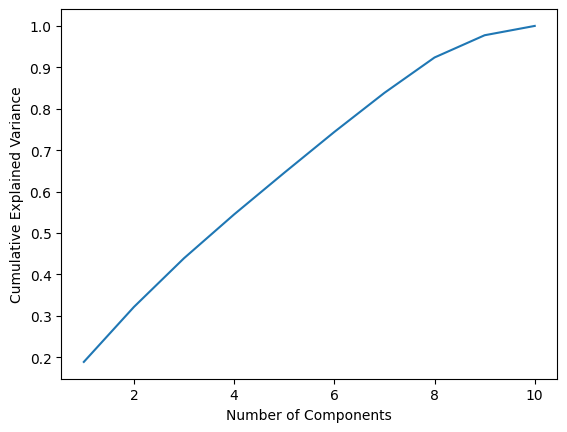

In [37]:
from sklearn.decomposition import PCA

scaler_all = StandardScaler()
scaled_data = scaler_all.fit_transform(train_df.drop(columns=['Y']))

pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# Visualize explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

This shows that we can keep the 10 columns to achieve maximum accuracy when predicting the target.

# Modeling

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

X = train_df.drop('Y', axis=1)  
y = train_df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

split_train = X_train.copy()
split_train['Y'] = y_train

In [39]:
# best 5 by RFE Selected features: Index(['X4', 'X7', 'X8', 'X9', 'X10'], dtype='object')

In [40]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

# feature_importances = rf.feature_importances_

# feature_importance_df = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': feature_importances
# })

# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# print("Top Features Based on Importance:\n", feature_importance_df.head(10))

# top_n_features = feature_importance_df['Feature'][:10]
# X_train_selected = X_train[top_n_features]
# X_test_selected = X_test[top_n_features]

# # Output
# # Top Features Based on Importance:
# #    Feature  Importance
# # 3      X8    0.390604
# # 2      X7    0.287835
# # 5     X10    0.171719
# # 4      X9    0.139435
# # 1      X4    0.010021
# # 0      X1    0.000386

## Bayesian Networks

In [41]:
# pip install pgmpy

In [42]:
train_df.isnull().sum()

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
Y      0
dtype: int64

In [43]:
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

hc = HillClimbSearch(train_df)
best_model = hc.estimate(scoring_method=BicScore(train_df))

# hc = HillClimbSearch(split_train)
# best_model = hc.estimate(scoring_method=BicScore(split_train))

print("Edges:", best_model.edges())

model = BayesianNetwork(best_model.edges())
model.fit(train_df, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges: [('X3', 'X5'), ('X7', 'X9'), ('X7', 'X10'), ('X7', 'Y'), ('X8', 'X7')]


In [44]:
# for node in model.nodes():
#     print(f"CPD for {node}:\n", model.get_cpds(node))

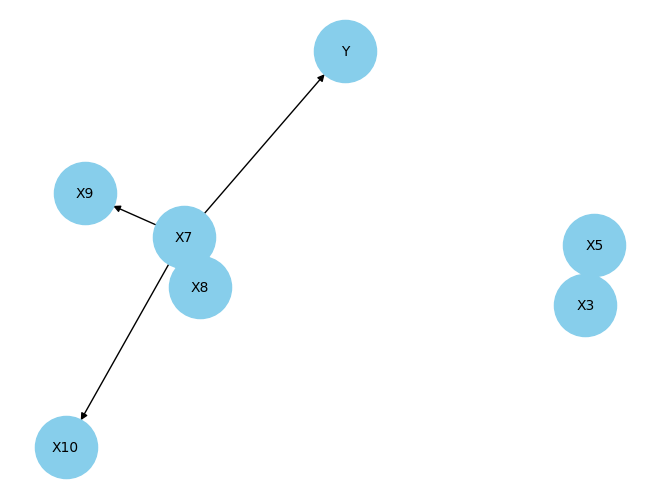

In [45]:
import networkx as nx

nx_graph = nx.DiGraph(best_model.edges())

nx.draw(nx_graph, with_labels=True, node_size=2000, node_color='skyblue', font_size=10)
plt.show()

In [46]:
X_test_pred = X_test.drop(columns=['X2', 'X1', 'X4', 'X6'])

predictions = model.predict(X_test_pred)

predicted_y = predictions['Y']

predicted_y = predicted_y.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

accuracy = (predicted_y == y_test).mean()
print("Prediction Accuracy:", accuracy)

  0%|          | 0/257 [00:00<?, ?it/s]

Prediction Accuracy: 1.0


## Actual test

In [47]:
tst_df['X9']=tst_df['X9'].fillna('Unknown')
tst_df['X9'] = tst_df['X9'].map(mapping_X9)
tst_df['X1'] = tst_df['X1'].map(frequency_encoding)
tst_df['X3'] = tst_df['X3'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
tst_df['X10'] = oe_X10.fit_transform(tst_df[['X10']])
tst_df['X3'] = le_X3.fit_transform(tst_df['X3'])
tst_df['X5'] = le_X5.fit_transform(tst_df['X5'])
tst_df['X7'] = le_X7.fit_transform(tst_df['X7'])
tst_df['X2'] = X2_imputer.fit_transform(tst_df[['X2']])
tst_df['X4'] = tst_df['X4'].clip(lower=lower_bound_X4, upper=upper_bound_X4)

tst_df[num_cols] = num_col_scaler.fit_transform(tst_df[num_cols])

In [48]:
tst_df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,2,0.964275,0,0.046189,13,0.323413,9,0.583333,2,0.0
1,3,0.222983,1,0.234630,4,0.235849,2,0.916667,0,1.0
2,5,0.598095,0,0.607981,11,0.894140,0,0.541667,0,2.0
3,6,0.164335,0,0.093958,13,0.524488,2,0.916667,0,1.0
4,5,0.473057,1,0.724139,4,0.862069,5,0.000000,2,2.0
...,...,...,...,...,...,...,...,...,...,...
5676,7,0.353974,1,0.082406,13,0.466011,8,0.500000,1,0.0
5677,6,0.181304,1,0.873068,15,0.584637,3,1.000000,2,2.0
5678,7,0.324204,0,0.448948,8,0.369798,7,0.708333,0,1.0
5679,5,0.639774,1,0.000000,3,0.778487,2,0.916667,0,1.0


In [49]:
X_test_pred = tst_df.drop(columns=['X2', 'X1', 'X4', 'X6'])

predictions = model.predict(X_test_pred)

predicted_y = predictions['Y']

# predicted_y = predicted_y.reset_index(drop=True)

  0%|          | 0/271 [00:00<?, ?it/s]

In [50]:
# predictions

In [51]:
submission = pd.DataFrame({
    'row_id': tst_df.index,
    'label': predicted_y          
})
submission

,row_id,label
0,0,0
1,1,0
2,2,1
3,3,0
4,4,3
...,...,...
5676,5676,0
5677,5677,2
5678,5678,0
5679,5679,0


In [52]:
submission.to_csv('submission.csv', index=False)
print(os.getcwd()) 

/kaggle/working
